# In this notebook, we will demonstrate the inference of stellar properties using CNF<sub>asfgrid</sub> on _Kepler_ red giants.

In [2]:
import os, sys
import numpy as np
import scipy as sp
import scipy.stats
import corner
import itertools
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch, zuko
import pandas as pd
import torch.utils.data as utils
import random
import arviz as az
from tqdm import tqdm_notebook as tqdm
from copy import copy

print(torch.__version__, zuko.__version__)

assert zuko.__version__ == '0.3.2'

2.0.1+cu117 0.3.2


In [3]:
az.__version__

'0.12.1'

# Loading pre-trained flows.


## Here, we want to use input parameters $\mathbf{x}$ across the entire grid to condition the normalizing flow. We then sample from the flow, we should give us the distribution of observables from the grid.

### $\mathbf{x} = [M, \text{[Fe/H]}]$
### $\mathbf{y} = [T_{\mathrm{eff}}, \Delta\nu, \nu_{\mathrm{max}}, R, \tau]$


### We have trained a one flow for the entire grid of models. To easily control which population we sample from, we define a categorical variable $E\in [-1, 0, 1, 2]$, where:

-1 : Subgiant stars ($\nu_{\mathrm{max}}\geq300\mu$ Hz) and hydrogen shell-burning

0 : Lower giant branch stars (10 $\mu$Hz \leq $\nu_{\mathrm{max}}< 300\mu$Hz) and hydrogen shell-burning

1 : Upper giant branch stars ($\nu_{\mathrm{max}}< 10\mu$Hz) and hydrogen shell-burning

2:  Helium core-burning stars

In [54]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

loadpath = os.path.split(os.getcwd())[0] + '/modelflows/pretrained_flows/cnf_asfgrid.checkpoint'
checkpoint = torch.load(loadpath)

flow= zuko.flows.NSF(features=5,  context=3, transforms=8, hidden_features=[512] * 8).to(device)
flow.load_state_dict(checkpoint['model_state_dict'])

print("=> Flow loaded at checkpoint (epoch {} - loss {})" .format(checkpoint['epoch'], checkpoint['loss']))

=> Flow loaded at checkpoint (epoch 400 - loss -30.71183765207538)


# Using SIR to infer the mass and radius of stars in the Yu et al. catalog. Let us first import the relevant data.

In [55]:
jie_data1 = pd.read_csv(os.path.split(os.getcwd())[0] + '/modelflows/data/inference/JieData_Full2018.txt', delimiter='|')
jie_data2 = pd.read_csv(os.path.split(os.getcwd())[0] + '/modelflows/data/inference/JieData_Mass2018.txt', delimiter='|')
jie_data = jie_data1.merge(jie_data2, on='KICID')

jie_mass, jie_mass_err = [], []
jie_radius, jie_radius_err = [], []

for i in range(len(jie_data)):
    if jie_data['EvoPhase'].values[i] == 0:
        jie_mass.append(jie_data['M_noCorrection'].values[i])
        jie_mass_err.append(jie_data['err.3'].values[i])
        jie_radius.append(jie_data['R_noCorrection'].values[i])
        jie_radius_err.append(jie_data['err.4'].values[i])
        
    elif jie_data['EvoPhase'].values[i] == 1:
        jie_mass.append(jie_data['M_RGB'].values[i])
        jie_mass_err.append(jie_data['err.5'].values[i])
        jie_radius.append(jie_data['R_RGB'].values[i])
        jie_radius_err.append(jie_data['err.6'].values[i])
        
    else:
        jie_mass.append(jie_data['M_Clump'].values[i])
        jie_mass_err.append(jie_data['err.7'].values[i])
        jie_radius.append(jie_data['R_Clump'].values[i])
        jie_radius_err.append(jie_data['err.8'].values[i]) 

jie_data['eff_mass'], jie_data['eff_mass_err'] = jie_mass, jie_mass_err
jie_data['eff_radius'], jie_data['eff_radius_err'] = jie_radius, jie_radius_err

jie_data = jie_data[jie_data.EvoPhase != 0]
jie_data['EvoPhase'][(jie_data.EvoPhase == 1) & (jie_data.numax > 10)] = 0 # our lower RGB criterion

## Defining helper functions.

### Salpeter IMF

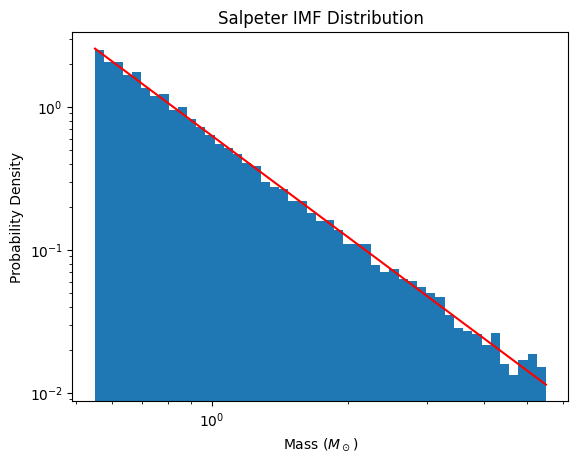

In [7]:
def salpeter_imf(mass_range, alpha=2.35, size=1000):
    """
    Generate stellar masses according to the Salpeter IMF.

    Parameters:
    - mass_range: tuple or list, (min_mass, max_mass) in solar masses.
    - alpha: float, the exponent of the IMF.
    - size: int, number of stellar masses to generate.

    Returns:
    - masses: ndarray, generated stellar masses according to the Salpeter IMF.
    """
    min_mass, max_mass = mass_range
    # Convert mass limits to scale between 0 and 1 for inverse transform sampling
    min_mass_scaled = min_mass**(1.0 - alpha)
    max_mass_scaled = max_mass**(1.0 - alpha)

    # Uniform random numbers for inverse transform sampling
    random_samples = np.random.uniform(low=min_mass_scaled, high=max_mass_scaled, size=size)

    # Applying the inverse of the CDF to get masses distributed according to the Salpeter IMF
    masses = random_samples**(1.0 / (1.0 - alpha))

    return masses

min_mass = 0.55  # Minimum mass in solar masses
max_mass = 5.5  # Maximum mass in solar masses
masses = salpeter_imf((min_mass, max_mass), size=10000)

mass_range = np.linspace(min_mass, max_mass, 1000)
theoretical_imf = mass_range**(-2.35)

plt.hist(masses, bins=np.logspace(np.log10(min_mass), np.log10(max_mass), 50), density=True)
plt.plot(mass_range, theoretical_imf / np.sum(theoretical_imf * np.diff(mass_range)[0]), label='Salpeter IMF', color='red')  # Normalized
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Mass ($M_\odot$)')
plt.ylabel('Probability Density')
plt.title('Salpeter IMF Distribution')
plt.show()

### Draws samples and weight them by their observed likelihoods

In [8]:
def infer_samples(flow, cvar):
    """
    Draws samples from the normalizing flow model.

    Args:
        flow: Normalizing flow model.
        cvar: Numpy array of size (batch x conditioning variable dims) containing the conditioning variables.
        num_samples: Number of samples per conditioning variable (default 1).

    Returns:
        ss2: Numpy array of size (batch x output dims) containing samples from the normalizing flow modelling the distribution.

    """

    with torch.no_grad():
        ss2, ss_logprobs = flow(torch.Tensor(cvar).to(device)).rsample_and_log_prob((1,))
        ss_logprobs = ss_logprobs.data.cpu().numpy().squeeze()
        ss2 = (ss2.data.cpu().numpy().squeeze())

    return ss2


def likelihood_batch(ss2, test_numax, test_numax_err, test_dnu, test_dnu_err,
                      test_teff, test_teff_err):
    """
    Weight the output flow samples using a Gaussian centered about observed values
    with a FWHM of the observed values uncertainty.  Return only samples with non-zero
    weights.

    Args:
        ss2: Numpy array of size (batch x output dims) containing samples from the normalizing flow.
        test_numax: Observed numax values.
        test_numax_err: Observed numax uncertainties.
        test_dnu: Observed DeltaNu values.
        test_dnu_err: Observed DeltaNu uncertainties.
        test_teff: Observed effective temperature values.
        test_teff_err: Observed temperature uncertainties.


    Returns:
        likelihood: Likelihood of samples being drawn based on combined weights from observables.
        ss2: All samples with non-zero weight.

    """

    
    if len(ss2.shape) == 2:
        ss2 = np.expand_dims(ss2, 0)

    pred_numax = 10**ss2[:,:,2]
    pred_dnu = 10**ss2[:,:,1]
    pred_radius = 10**ss2[:,:,-2]
    pred_age = 10**ss2[:,:,-1]
    pred_teff = 10**(ss2[:,:,0]).squeeze()
    

    draw_prob_numax = 1/(test_numax_err*np.sqrt(2*np.pi))  * np.exp(-0.5*np.power( pred_numax - test_numax, 2)/ test_numax_err**2)
    draw_prob_dnu = 1/(test_dnu_err*np.sqrt(2*np.pi))  * np.exp(-0.5*np.power( pred_dnu - test_dnu, 2)/ test_dnu_err**2)
    draw_prob_teff = 1/(test_teff_err*np.sqrt(2*np.pi))  * np.exp(-0.5*np.power( pred_teff - test_teff, 2)/ test_teff_err**2)
     
    likelihood = draw_prob_numax * draw_prob_teff * draw_prob_dnu

    return likelihood.squeeze(), ss2[likelihood != 0]



### We can define a function that runs one instance of sampling through the flow

In [12]:
def sample_batch(flow, num_samples, inp_data, sample_idx):
    """
    Draws a batch of samples from the flow and weight the samples according to the observables.
    
    Args:
        flow: The conditional normalizing flow.
        num_samples: Number of samples to draw from the normalizing flow.
        inp_data: pandas DataFrame of input data.
        sample_idx: Index of sample to test in inp_data.
    
    Returns:
        candidate_param_prob: Vector of shape (6xN) of non-zero likelihood draws of input parameters.
    """    

    num_marginals = num_samples   #  number of samples to be drawing from the flow

    ## Define initial parameters into the flow ##

    massvar= salpeter_imf((0.6, 5.5), size=num_marginals).T # mass samples from IMF
    fehvar =np.random.normal(loc=inp_data['Fe/H'].values[sample_idx],
                             scale=inp_data['err.2'].values[sample_idx], 
                             size=num_marginals).T # metallicity samples centered about observations

    
    cv = np.ones((num_marginals, 3))
    cv[:, 0] = massvar
    cv[:, 1] = fehvar
    cv[:, 2] = inp_data.EvoPhase.values[sample_idx]

    cvar = torch.Tensor(cv).to(device) ## create PyTorch tensor
    ss2 = infer_samples(flow, cvar) ## draw samples from the flow

    ## Weight samples ##
    
    combined_likelihood,  nonzero_samples, = likelihood_batch(ss2, 
                                                    inp_data.numax.values[sample_idx].reshape(-1,1),
                                                    inp_data.numax_err.values[sample_idx].reshape(-1,1),
                                                    inp_data.dnu.values[sample_idx].reshape(-1,1), 
                                                    inp_data.dnu_err.values[sample_idx].reshape(-1,1),
                                                    inp_data.Teff.values[sample_idx].reshape(-1,1),
                                                    inp_data.err.values[sample_idx].reshape(-1,1))  


    ## For simplicity we can discard samples with a probability so low they are effectively zero ## 

    remaining_likelihood = combined_likelihood[combined_likelihood != 0]
    candidate_mass = massvar[combined_likelihood != 0]
    candidate_feh = fehvar[combined_likelihood != 0]
    candidate_radius = 10**nonzero_samples[:, -2]
    candidate_teff = 10**nonzero_samples[:, -0]
    candidate_age = 10**nonzero_samples[:, -1]


    ## This defines the vector of remaining samples from which we will draw using weights defined by remaining_likelihood_feh

    candidate_param = [[a, m, f, r, t] for a, m, f, r, t in zip(candidate_age,
                                                                candidate_mass,
                                                                candidate_feh,
                                                                candidate_radius, 
                                                                candidate_teff)]
    
    if len(candidate_param) != 0:
        candidate_param_prob = np.hstack([np.array(candidate_param), remaining_likelihood.reshape(-1,1) ])
    else:
        return None
    
    return candidate_param_prob


# We are now ready to perform inference! Using `sample_batch`, simply pass an index of the desired dataframe (RGB or HeB) to get a prediction.

### We can draw as many samples as we like for Sampling/Importance Resampling to get posterior distributions (more is better), but let's define a simple criterion where we want a minimum number of unique values to have been drawn from the flow.


### We specify an evolutionary state indicator and dictionary 1 = RGB, 2 = HeB to use the correct flows and DataFrames accordingly.

In [58]:
jie_data.iloc[2]

KICID                 893214
kepmag                 12.58
Length_Quarters           15
Length_days           1211.9
numax                  41.39
numax_err               0.54
dnu                    4.311
dnu_err                0.013
amplitude               86.1
amp_err                  4.6
fwhm                    15.3
fwhm_err                 1.6
maxbg                 1337.0
maxbg_err              289.9
Unnamed: 14              NaN
Teff                    4728
err                       80
logg                   2.522
err.1                  0.008
Fe/H                   -0.15
err.2                   0.15
M_noCorrection          1.72
err.3                    0.1
R_noCorrection          11.9
err.4                   0.26
M_RGB                   1.54
err.5                   0.09
R_RGB                  11.29
err.6                   0.24
M_Clump                 1.72
err.7                    0.1
R_Clump                11.92
err.8                   0.26
EvoPhase                   0
Unnamed: 20   

In [56]:
### This step applies SIR. We draw 100000 samples from the flow per batch ###

sample_idx = 2

print('Running Inference on KIC %d, EvoPhase: %d' %(jie_data.KICID.values[sample_idx],
                                                   jie_data.EvoPhase.values[sample_idx]))

candidate_param_prob = sample_batch(flow,
                                    100000, jie_data,
                                   sample_idx)

### We use the weights to define a discrete probability distribution over the candidate values ###
sir_samples = np.array(random.choices(candidate_param_prob, 
                             weights=(candidate_param_prob[:, -1]), k=100000))
unique_age, unique_indices = np.unique(sir_samples[:,0], return_index=True)
print('Unique Age Samples: %d' %len(unique_age))

### Set criterion for drawing more ####

while len(unique_age) < 1000:
    extra_param_prob = sample_batch(flow,
                                    100000, jie_data,
                                   sample_idx)
    extra_samples = np.array(random.choices(extra_param_prob, 
                                 weights=(extra_param_prob[:, -1]), k=100000))
    sir_samples = np.concatenate([sir_samples, extra_samples])
    unique_age, unique_indices = np.unique(sir_samples[:,0], return_index=True)
    print('Unique Age Samples: %d' %len(unique_age))
print('Done!')

Running Inference on KIC 893214, EvoPhase: 0
Unique Age Samples: 168
Unique Age Samples: 349
Unique Age Samples: 529
Unique Age Samples: 689
Unique Age Samples: 869
Unique Age Samples: 1024
Done!


# The SIR samples form our posterior distribution for a given star.

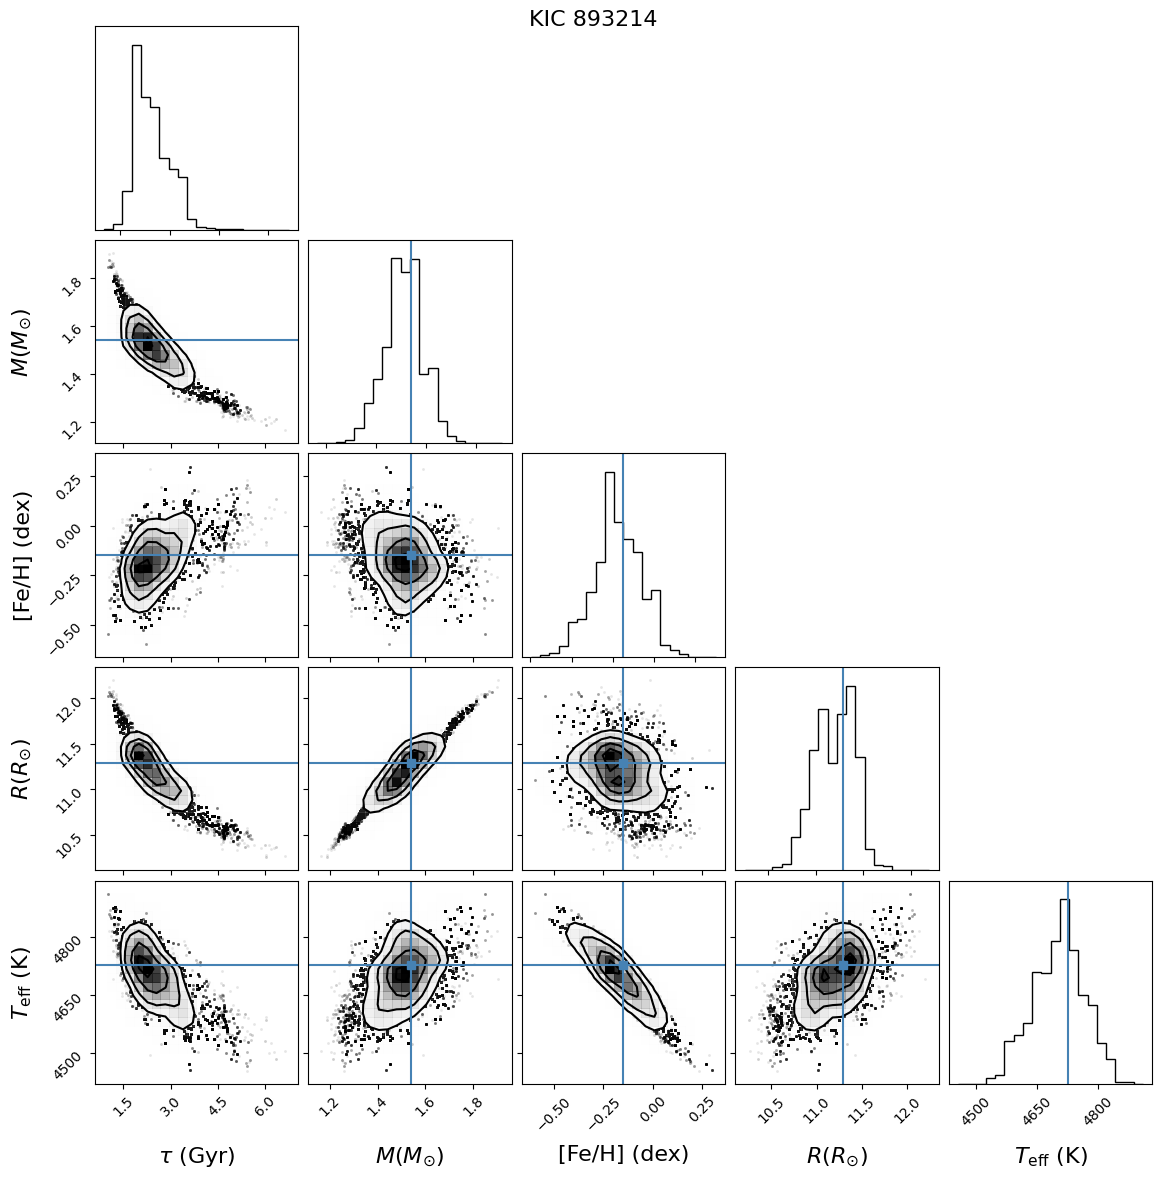

In [57]:
import corner

ndim = 5

fig = plt.figure(figsize=(12,12))
fs = 16
labels = ['$\\tau$ (Gyr)', '$M (M_{\\odot})$', '[Fe/H] (dex)', '$R (R_{\\odot})$', '$T_{\\mathrm{eff}}$ (K)']

truths = [None, jie_data['eff_mass'].values[sample_idx],
          jie_data['Fe/H'].values[sample_idx],
          jie_data['eff_radius'].values[sample_idx],
          jie_data['Teff'].values[sample_idx]]

corner.corner(sir_samples[:, :-1], labels=labels,label_kwargs={"fontsize": fs}, fig=fig, smooth = 1.,
              hist_kwargs={'density':True}, truths=truths)

for ax in fig.get_axes():
    ax.tick_params(axis='both', labelsize=fs-6) 
    
plt.suptitle('KIC %d' %(jie_data.KICID.values[sample_idx]), fontsize = fs)
plt.show()

### For this example (index 1 RGB), we see that the literature values for mass and radius (indicated in blue) agrees well with our posteriors.

In [39]:
hdis, medians = az.hdi(np.array(sir_samples[:,:-1])),  np.median(np.array(sir_samples[:,:-1]), axis=0)

labels = ['Age (Gyr)', 'Mass (Msol)', '[Fe/H] (dex)', 'Radius (Rsol)', 'Teff (K)']
for i, (hdi, median) in enumerate(zip(hdis,medians)):
    print('%s: %.2f +%.2f -%.2f' %(labels[i], median, median-hdi[0], hdi[1] - median))

<ipython-input-39-8ada44e6cf6f>:1: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdis, medians = az.hdi(np.array(sir_samples[:,:-1])),  np.median(np.array(sir_samples[:,:-1]), axis=0)


Age (Gyr): 2.37 +0.75 -1.04
Mass (Msol): 1.51 +0.15 -0.14
[Fe/H] (dex): -0.16 +0.22 -0.20
Radius (Rsol): 11.20 +0.42 -0.31
Teff (K): 4699.67 +108.74 -126.59


# We now turn to another example, where we estimate the mass and radius of a massive clump star (KIC 3347458)

In [45]:
sample_idx = np.where(jie_data.KICID.values == 3347458)[0].squeeze() # 3347458, 4756133 

print('Running Inference on KIC %d' %(jie_data.KICID.values[sample_idx]))

candidate_param_prob = sample_batch(flow,
                                    100000, jie_data,
                                   sample_idx)

### We use the weights to define a discrete probability distribution over the candidate values ###
sir_samples = np.array(random.choices(candidate_param_prob, 
                             weights=(candidate_param_prob[:, -1]), k=100000))
unique_age, unique_indices = np.unique(sir_samples[:,0], return_index=True)
print('Unique Age Samples: %d' %len(unique_age))

### Set criterion for drawing more ####

while len(unique_age) < 1000:
    extra_param_prob = sample_batch(flow,
                                    100000, jie_data,
                                   sample_idx)
    extra_samples = np.array(random.choices(extra_param_prob, 
                                 weights=(extra_param_prob[:, -1]), k=100000))
    sir_samples = np.concatenate([sir_samples, extra_samples])
    unique_age, unique_indices = np.unique(sir_samples[:,0], return_index=True)
    print('Unique Age Samples: %d' %len(unique_age))
print('Done!')

Running Inference on KIC 3347458
Unique Age Samples: 173
Unique Age Samples: 386
Unique Age Samples: 574
Unique Age Samples: 773
Unique Age Samples: 934
Unique Age Samples: 1108
Done!


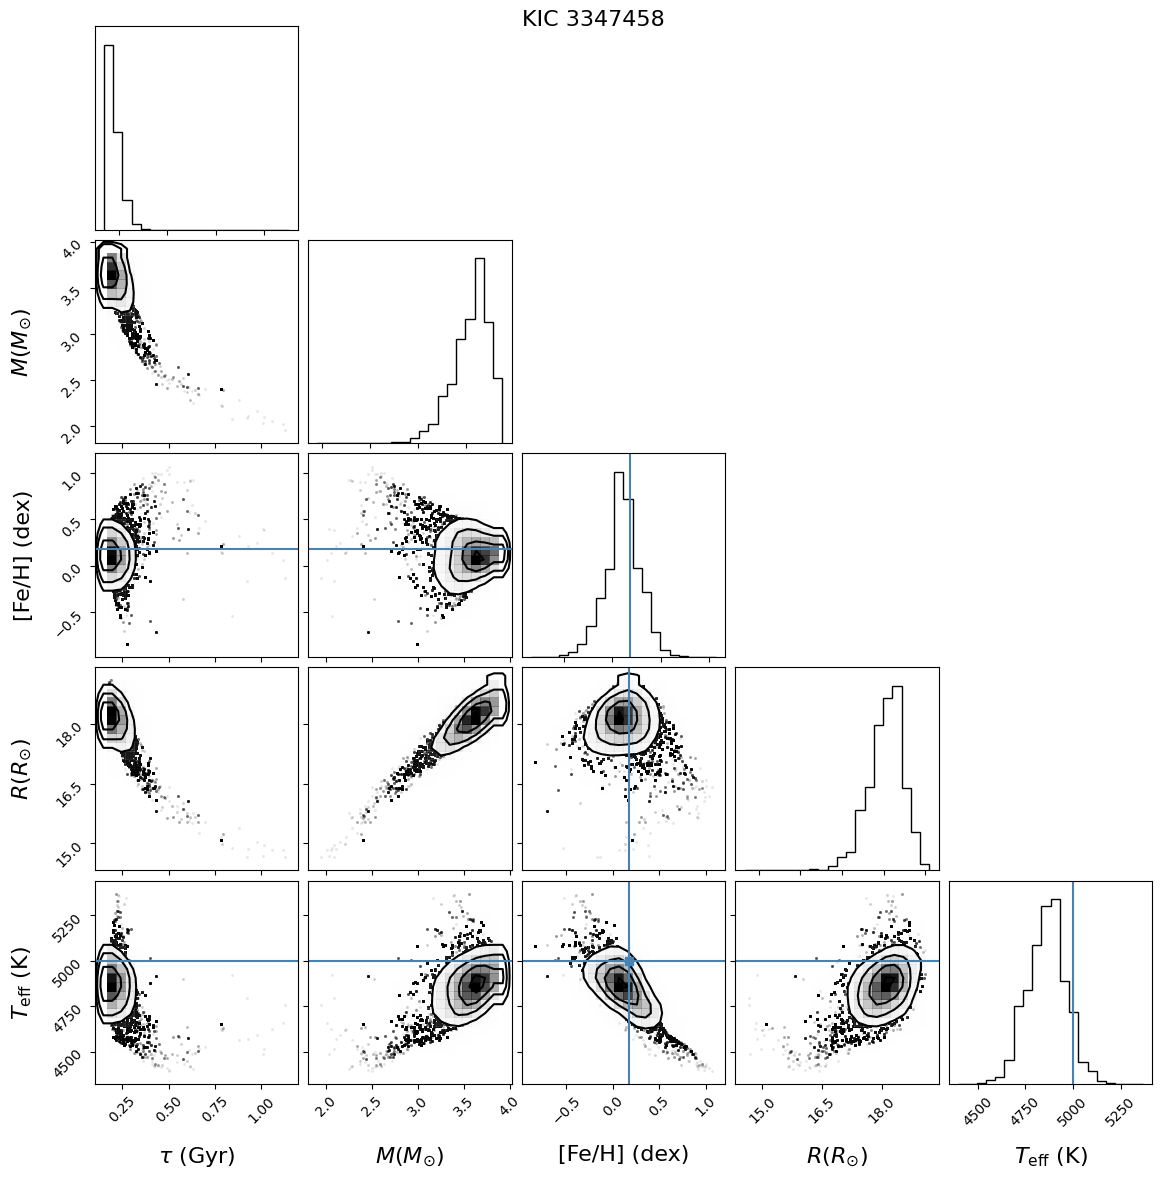

In [46]:
import corner

ndim = 5

fig = plt.figure(figsize=(12,12))
fs = 16
labels = ['$\\tau$ (Gyr)', '$M (M_{\\odot})$', '[Fe/H] (dex)', '$R (R_{\\odot})$', '$T_{\\mathrm{eff}}$ (K)']

truths = [None, jie_data['eff_mass'].values[sample_idx],
          jie_data['Fe/H'].values[sample_idx],
          jie_data['eff_radius'].values[sample_idx],
          jie_data['Teff'].values[sample_idx]]

corner.corner(sir_samples[:, :-1], labels=labels,label_kwargs={"fontsize": fs}, fig=fig, smooth = 1.,
              hist_kwargs={'density':True}, truths=truths)

for ax in fig.get_axes():
    ax.tick_params(axis='both', labelsize=fs-6) 
    
plt.suptitle('KIC %d' %(jie_data.KICID.values[sample_idx]), fontsize = fs)
plt.show()

In [47]:
hdis, medians = az.hdi(np.array(sir_samples[:,:-1])),  np.median(np.array(sir_samples[:,:-1]), axis=0)

labels = ['Age (Gyr)', 'Mass (Msol)', '[Fe/H] (dex)', 'Radius (Rsol)', 'Teff (K)']
for i, (hdi, median) in enumerate(zip(hdis,medians)):
    print('%s: %.2f +%.2f -%.2f' %(labels[i], median, median-hdi[0], hdi[1] - median))

<ipython-input-47-8ada44e6cf6f>:1: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdis, medians = az.hdi(np.array(sir_samples[:,:-1])),  np.median(np.array(sir_samples[:,:-1]), axis=0)


Age (Gyr): 0.21 +0.04 -0.07
Mass (Msol): 3.59 +0.38 -0.26
[Fe/H] (dex): 0.11 +0.34 -0.32
Radius (Rsol): 18.09 +0.77 -0.69
Teff (K): 4865.74 +176.17 -190.40
